# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [42]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

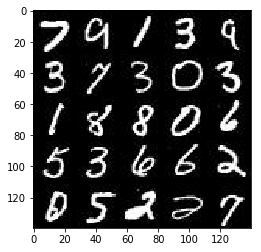

In [43]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

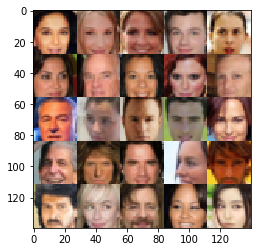

In [44]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [46]:
# from subprocess import check_output
# check_output(["nvidia-smi"])

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [47]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [48]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    stddev = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
        # ?x14x14x128 now
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # ?x7x7x128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # ?x7x7x256 now

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        # ?x1 now

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [49]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    stddev = 0.1
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # ?x7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # ?x14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # ?x28x28x128 now  
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # ?x28x28x3 (if RGB) now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [64]:
import sys

def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [51]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(
    epoch_count,
    batch_size,
    z_dim,
    learning_rate,
    beta1,
    get_batches,
    data_shape,
    data_image_mode,
    alpha,
    print_every,
    show_every
):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data, e.g., '60000, 28, 28, 1'
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # tf.reset_default_graph()
        
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            
            batch_numb = 0
            
            for batch_images in get_batches(batch_size):

                batch_numb += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(
                    d_opt, 
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tensor:
                        learning_rate
                    }
                )
                
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tensor: learning_rate
                    }
                )
                
                if batch_numb % print_every == 0:
                    # get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print(
                        "Batch {}/{}...".format(batch_numb, data_shape[0]//batch_size),
                        "Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    
                if batch_numb % show_every == 0:
                    show_generator_output(
                        sess,
                        25,
                        input_z,
                        data_shape[3],
                        data_image_mode
                    )
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch 10/937... Epoch 1/2... Discriminator Loss: 0.5084... Generator Loss: 6.6750
Batch 20/937... Epoch 1/2... Discriminator Loss: 0.0803... Generator Loss: 3.3961
Batch 30/937... Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 7.2725
Batch 40/937... Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 6.6000
Batch 50/937... Epoch 1/2... Discriminator Loss: 5.6987... Generator Loss: 0.0142
Batch 60/937... Epoch 1/2... Discriminator Loss: 0.3213... Generator Loss: 2.0526
Batch 70/937... Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.3991
Batch 80/937... Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 2.9234
Batch 90/937... Epoch 1/2... Discriminator Loss: 0.2699... Generator Loss: 2.8726
Batch 100/937... Epoch 1/2... Discriminator Loss: 0.1411... Generator Loss: 3.2732


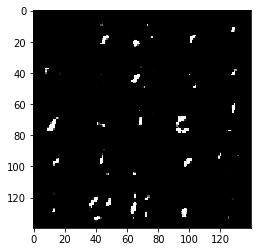

Batch 110/937... Epoch 1/2... Discriminator Loss: 0.1533... Generator Loss: 2.4192
Batch 120/937... Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 4.1767
Batch 130/937... Epoch 1/2... Discriminator Loss: 0.0595... Generator Loss: 3.9824
Batch 140/937... Epoch 1/2... Discriminator Loss: 0.0666... Generator Loss: 3.4832
Batch 150/937... Epoch 1/2... Discriminator Loss: 0.0365... Generator Loss: 3.9127
Batch 160/937... Epoch 1/2... Discriminator Loss: 0.0344... Generator Loss: 4.3620
Batch 170/937... Epoch 1/2... Discriminator Loss: 0.0318... Generator Loss: 4.3285
Batch 180/937... Epoch 1/2... Discriminator Loss: 0.0266... Generator Loss: 5.1162
Batch 190/937... Epoch 1/2... Discriminator Loss: 2.6071... Generator Loss: 4.9216
Batch 200/937... Epoch 1/2... Discriminator Loss: 3.1735... Generator Loss: 0.1867


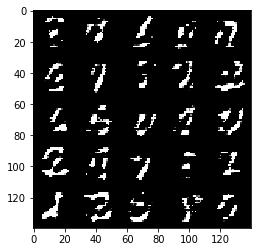

Batch 210/937... Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 3.7235
Batch 220/937... Epoch 1/2... Discriminator Loss: 0.1339... Generator Loss: 4.7214
Batch 230/937... Epoch 1/2... Discriminator Loss: 0.2064... Generator Loss: 2.6386
Batch 240/937... Epoch 1/2... Discriminator Loss: 0.3410... Generator Loss: 4.5458
Batch 250/937... Epoch 1/2... Discriminator Loss: 0.0842... Generator Loss: 3.5230
Batch 260/937... Epoch 1/2... Discriminator Loss: 0.1186... Generator Loss: 3.4666
Batch 270/937... Epoch 1/2... Discriminator Loss: 0.2870... Generator Loss: 2.0857
Batch 280/937... Epoch 1/2... Discriminator Loss: 6.2306... Generator Loss: 0.0092
Batch 290/937... Epoch 1/2... Discriminator Loss: 1.6775... Generator Loss: 3.4241
Batch 300/937... Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.5196


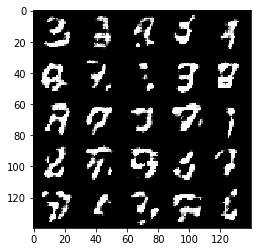

Batch 310/937... Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 2.1594
Batch 320/937... Epoch 1/2... Discriminator Loss: 1.8904... Generator Loss: 3.2574
Batch 330/937... Epoch 1/2... Discriminator Loss: 3.1877... Generator Loss: 2.6912
Batch 340/937... Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7155
Batch 350/937... Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 2.7548
Batch 360/937... Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 2.2889
Batch 370/937... Epoch 1/2... Discriminator Loss: 1.9684... Generator Loss: 0.2711
Batch 380/937... Epoch 1/2... Discriminator Loss: 2.1261... Generator Loss: 3.6083
Batch 390/937... Epoch 1/2... Discriminator Loss: 1.7928... Generator Loss: 0.3591
Batch 400/937... Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 3.1118


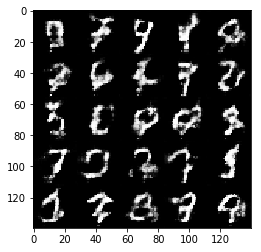

Batch 410/937... Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.6726
Batch 420/937... Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 1.7180
Batch 430/937... Epoch 1/2... Discriminator Loss: 2.0763... Generator Loss: 0.2616
Batch 440/937... Epoch 1/2... Discriminator Loss: 2.0225... Generator Loss: 0.2244
Batch 450/937... Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.9093
Batch 460/937... Epoch 1/2... Discriminator Loss: 1.5846... Generator Loss: 1.3088
Batch 470/937... Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 2.4846
Batch 480/937... Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.9463
Batch 490/937... Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 1.2353
Batch 500/937... Epoch 1/2... Discriminator Loss: 1.9568... Generator Loss: 2.1060


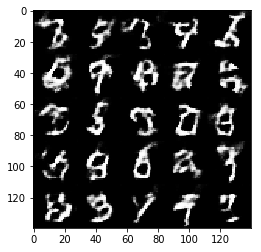

Batch 510/937... Epoch 1/2... Discriminator Loss: 2.1125... Generator Loss: 0.1913
Batch 520/937... Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.5889
Batch 530/937... Epoch 1/2... Discriminator Loss: 1.6678... Generator Loss: 0.2972
Batch 540/937... Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.3325
Batch 550/937... Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 1.5931
Batch 560/937... Epoch 1/2... Discriminator Loss: 1.9468... Generator Loss: 0.2210
Batch 570/937... Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.7206
Batch 580/937... Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.2588
Batch 590/937... Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.4391
Batch 600/937... Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.6415


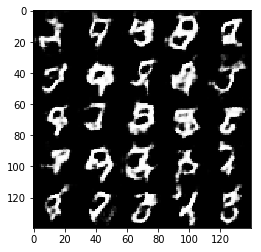

Batch 610/937... Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 0.3728
Batch 620/937... Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.4830
Batch 630/937... Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 0.6353
Batch 640/937... Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.3844
Batch 650/937... Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.8154
Batch 660/937... Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 1.4424
Batch 670/937... Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.8275
Batch 680/937... Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 1.6403
Batch 690/937... Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 0.3355
Batch 700/937... Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 1.1935


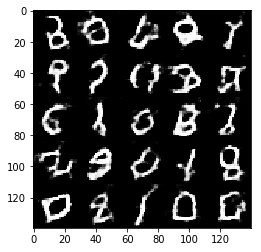

Batch 710/937... Epoch 1/2... Discriminator Loss: 1.8448... Generator Loss: 0.2660
Batch 720/937... Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.4148
Batch 730/937... Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 1.3148
Batch 740/937... Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 1.7414
Batch 750/937... Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.2942
Batch 760/937... Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.9257
Batch 770/937... Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.5748
Batch 780/937... Epoch 1/2... Discriminator Loss: 1.5548... Generator Loss: 2.2707
Batch 790/937... Epoch 1/2... Discriminator Loss: 1.6113... Generator Loss: 0.3760
Batch 800/937... Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.4593


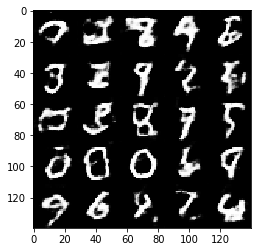

Batch 810/937... Epoch 1/2... Discriminator Loss: 1.8254... Generator Loss: 2.0352
Batch 820/937... Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 1.7062
Batch 830/937... Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 1.3010
Batch 840/937... Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.7842
Batch 850/937... Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 1.2936
Batch 860/937... Epoch 1/2... Discriminator Loss: 1.7279... Generator Loss: 0.3067
Batch 870/937... Epoch 1/2... Discriminator Loss: 1.7006... Generator Loss: 0.3909
Batch 880/937... Epoch 1/2... Discriminator Loss: 2.0938... Generator Loss: 1.9224
Batch 890/937... Epoch 1/2... Discriminator Loss: 1.6395... Generator Loss: 1.8434
Batch 900/937... Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.8301


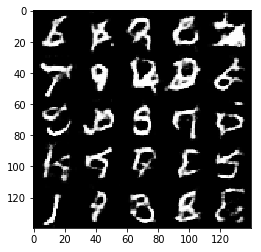

Batch 910/937... Epoch 1/2... Discriminator Loss: 1.7022... Generator Loss: 1.6360
Batch 920/937... Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.4295
Batch 930/937... Epoch 1/2... Discriminator Loss: 2.5021... Generator Loss: 0.1152
Batch 10/937... Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 1.3192
Batch 20/937... Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 1.1195
Batch 30/937... Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.9843
Batch 40/937... Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.5526
Batch 50/937... Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 1.3631
Batch 60/937... Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 1.0157
Batch 70/937... Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.5176
Batch 80/937... Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 1.5305
Batch 90/937... Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.9695
Batch 100/937

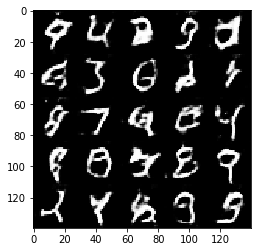

Batch 110/937... Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.4095
Batch 120/937... Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.9507
Batch 130/937... Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.9805
Batch 140/937... Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 2.4316
Batch 150/937... Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.4857
Batch 160/937... Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 0.8277
Batch 170/937... Epoch 2/2... Discriminator Loss: 1.7277... Generator Loss: 2.9081
Batch 180/937... Epoch 2/2... Discriminator Loss: 1.5627... Generator Loss: 0.3478
Batch 190/937... Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.5279
Batch 200/937... Epoch 2/2... Discriminator Loss: 1.6263... Generator Loss: 2.0255


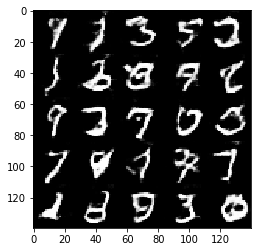

Batch 210/937... Epoch 2/2... Discriminator Loss: 1.4236... Generator Loss: 0.3541
Batch 220/937... Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.6651
Batch 230/937... Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.6804
Batch 240/937... Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 1.0871
Batch 250/937... Epoch 2/2... Discriminator Loss: 1.5569... Generator Loss: 0.3218
Batch 260/937... Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.7644
Batch 270/937... Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.9595
Batch 280/937... Epoch 2/2... Discriminator Loss: 5.6100... Generator Loss: 5.7412
Batch 290/937... Epoch 2/2... Discriminator Loss: 1.4345... Generator Loss: 0.4349
Batch 300/937... Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 1.1631


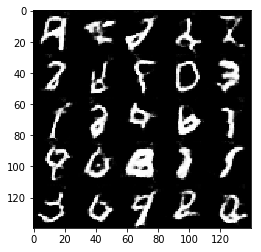

Batch 310/937... Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.9289
Batch 320/937... Epoch 2/2... Discriminator Loss: 1.4703... Generator Loss: 1.1779
Batch 330/937... Epoch 2/2... Discriminator Loss: 2.8013... Generator Loss: 0.0951
Batch 340/937... Epoch 2/2... Discriminator Loss: 1.5849... Generator Loss: 0.3366
Batch 350/937... Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.9403
Batch 360/937... Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.0911
Batch 370/937... Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.4726
Batch 380/937... Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 1.3462
Batch 390/937... Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 0.5635
Batch 400/937... Epoch 2/2... Discriminator Loss: 1.5241... Generator Loss: 0.3464


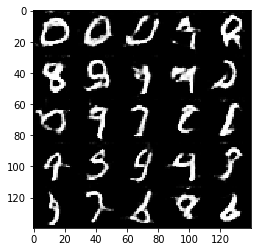

Batch 410/937... Epoch 2/2... Discriminator Loss: 1.6136... Generator Loss: 2.6868
Batch 420/937... Epoch 2/2... Discriminator Loss: 1.4165... Generator Loss: 0.4018
Batch 430/937... Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.3408
Batch 440/937... Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.8398
Batch 450/937... Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 0.8292
Batch 460/937... Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 0.8184
Batch 470/937... Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 1.9948
Batch 480/937... Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.3495
Batch 490/937... Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 1.3397
Batch 500/937... Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.7070


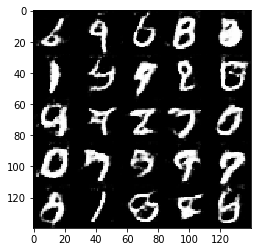

Batch 510/937... Epoch 2/2... Discriminator Loss: 1.5819... Generator Loss: 0.3535
Batch 520/937... Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.0704
Batch 530/937... Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.4574
Batch 540/937... Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.3444
Batch 550/937... Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 1.0593
Batch 560/937... Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 1.0435
Batch 570/937... Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.7926
Batch 580/937... Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.3713
Batch 590/937... Epoch 2/2... Discriminator Loss: 2.5910... Generator Loss: 2.5794
Batch 600/937... Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 1.4766


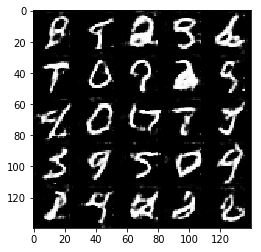

Batch 610/937... Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.0605
Batch 620/937... Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.4934
Batch 630/937... Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.5430
Batch 640/937... Epoch 2/2... Discriminator Loss: 2.0455... Generator Loss: 0.1779
Batch 650/937... Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.5347
Batch 660/937... Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.7222
Batch 670/937... Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 1.2713
Batch 680/937... Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.4336
Batch 690/937... Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 0.8895
Batch 700/937... Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 2.1559


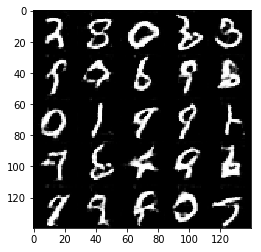

Batch 710/937... Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.6333
Batch 720/937... Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.4640
Batch 730/937... Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 0.2825
Batch 740/937... Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.7999
Batch 750/937... Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.5318
Batch 760/937... Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 0.4699
Batch 770/937... Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 1.0760
Batch 780/937... Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 2.0227
Batch 790/937... Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.5241
Batch 800/937... Epoch 2/2... Discriminator Loss: 1.5226... Generator Loss: 0.4065


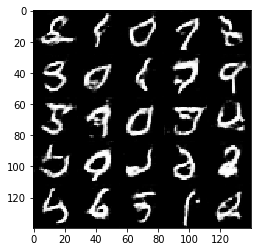

Batch 810/937... Epoch 2/2... Discriminator Loss: 1.8943... Generator Loss: 0.2473
Batch 820/937... Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.7352
Batch 830/937... Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 1.0438
Batch 840/937... Epoch 2/2... Discriminator Loss: 1.8170... Generator Loss: 0.2152
Batch 850/937... Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.5799
Batch 860/937... Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 1.4661
Batch 870/937... Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.7310
Batch 880/937... Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 1.0962
Batch 890/937... Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.8769
Batch 900/937... Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.8095


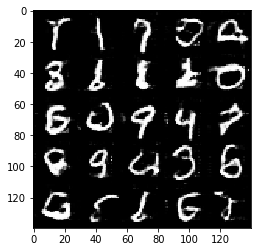

Batch 910/937... Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 1.5324
Batch 920/937... Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.6668
Batch 930/937... Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.7141


In [65]:
import sys

batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
alpha=0.2
print_every=10
show_every=100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(
        epochs,
        batch_size,
        z_dim,
        learning_rate,
        beta1,
        mnist_dataset.get_batches,
        mnist_dataset.shape,
        mnist_dataset.image_mode,
        alpha,
        print_every,
        show_every
    )

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch 10/3165... Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.9903
Batch 20/3165... Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 3.9633
Batch 30/3165... Epoch 1/1... Discriminator Loss: 2.4624... Generator Loss: 13.8782
Batch 40/3165... Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 2.4963
Batch 50/3165... Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 3.1356
Batch 60/3165... Epoch 1/1... Discriminator Loss: 0.1158... Generator Loss: 4.4559
Batch 70/3165... Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 2.3257
Batch 80/3165... Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 3.1428
Batch 90/3165... Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 3.8880
Batch 100/3165... Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 3.8888


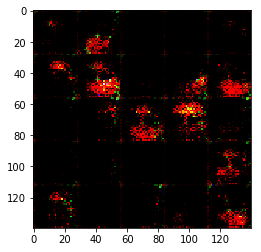

Batch 110/3165... Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 4.4408
Batch 120/3165... Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.6158
Batch 130/3165... Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 5.1950
Batch 140/3165... Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 4.6014
Batch 150/3165... Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 5.6687
Batch 160/3165... Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 4.8662
Batch 170/3165... Epoch 1/1... Discriminator Loss: 0.0766... Generator Loss: 3.2841
Batch 180/3165... Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 5.7872
Batch 190/3165... Epoch 1/1... Discriminator Loss: 13.6607... Generator Loss: 0.0001
Batch 200/3165... Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.1807


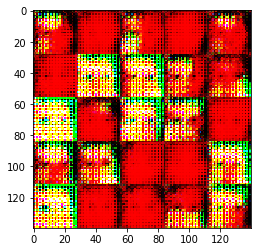

Batch 210/3165... Epoch 1/1... Discriminator Loss: 4.2745... Generator Loss: 0.0525
Batch 220/3165... Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 7.0559
Batch 230/3165... Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 9.9521
Batch 240/3165... Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 3.7731
Batch 250/3165... Epoch 1/1... Discriminator Loss: 15.0858... Generator Loss: 37.3263
Batch 260/3165... Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 6.2607
Batch 270/3165... Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 2.2861
Batch 280/3165... Epoch 1/1... Discriminator Loss: 0.1117... Generator Loss: 3.4183
Batch 290/3165... Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 13.5061
Batch 300/3165... Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 20.4012


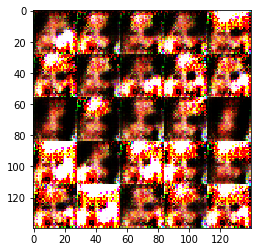

Batch 310/3165... Epoch 1/1... Discriminator Loss: 8.1935... Generator Loss: 21.3471
Batch 320/3165... Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 14.2751
Batch 330/3165... Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 15.1535
Batch 340/3165... Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 5.5984
Batch 350/3165... Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.3734
Batch 360/3165... Epoch 1/1... Discriminator Loss: 2.2636... Generator Loss: 0.3046
Batch 370/3165... Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.1450
Batch 380/3165... Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 1.2159
Batch 390/3165... Epoch 1/1... Discriminator Loss: 4.1268... Generator Loss: 0.1216
Batch 400/3165... Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 4.0344


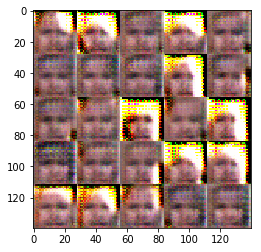

Batch 410/3165... Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 4.5327
Batch 420/3165... Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 8.4651
Batch 430/3165... Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 2.6386
Batch 440/3165... Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7725
Batch 450/3165... Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.3058
Batch 460/3165... Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 2.0717
Batch 470/3165... Epoch 1/1... Discriminator Loss: 2.1684... Generator Loss: 0.3225
Batch 480/3165... Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 1.2244
Batch 490/3165... Epoch 1/1... Discriminator Loss: 2.1745... Generator Loss: 0.4008
Batch 500/3165... Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 2.5294


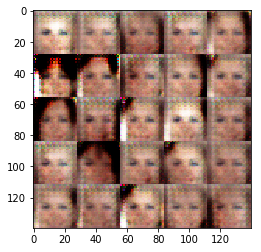

Batch 510/3165... Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.5233
Batch 520/3165... Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.3766
Batch 530/3165... Epoch 1/1... Discriminator Loss: 2.4548... Generator Loss: 0.1654
Batch 540/3165... Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 0.5263
Batch 550/3165... Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.1220
Batch 560/3165... Epoch 1/1... Discriminator Loss: 1.6935... Generator Loss: 2.1320
Batch 570/3165... Epoch 1/1... Discriminator Loss: 3.5348... Generator Loss: 4.2694
Batch 580/3165... Epoch 1/1... Discriminator Loss: 1.8500... Generator Loss: 0.4254
Batch 590/3165... Epoch 1/1... Discriminator Loss: 1.8168... Generator Loss: 1.0632
Batch 600/3165... Epoch 1/1... Discriminator Loss: 2.0845... Generator Loss: 2.9445


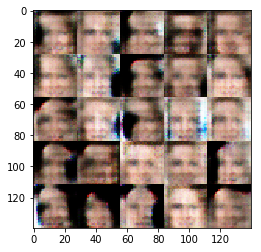

Batch 610/3165... Epoch 1/1... Discriminator Loss: 2.9932... Generator Loss: 3.1199
Batch 620/3165... Epoch 1/1... Discriminator Loss: 2.1906... Generator Loss: 3.0603
Batch 630/3165... Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.9402
Batch 640/3165... Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.9037
Batch 650/3165... Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 1.9078
Batch 660/3165... Epoch 1/1... Discriminator Loss: 1.6618... Generator Loss: 0.3995
Batch 670/3165... Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8371
Batch 680/3165... Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 2.6263
Batch 690/3165... Epoch 1/1... Discriminator Loss: 1.8992... Generator Loss: 2.6203
Batch 700/3165... Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.4199


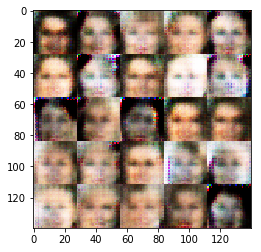

Batch 710/3165... Epoch 1/1... Discriminator Loss: 2.9052... Generator Loss: 0.0916
Batch 720/3165... Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.5245
Batch 730/3165... Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7874
Batch 740/3165... Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.8886
Batch 750/3165... Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 1.1891
Batch 760/3165... Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 2.0859
Batch 770/3165... Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.8504
Batch 780/3165... Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.5502
Batch 790/3165... Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6366
Batch 800/3165... Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.3447


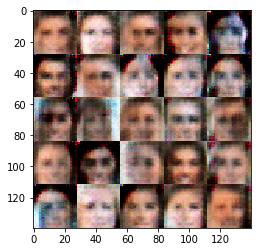

Batch 810/3165... Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.9434
Batch 820/3165... Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 2.1148
Batch 830/3165... Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5341
Batch 840/3165... Epoch 1/1... Discriminator Loss: 1.7830... Generator Loss: 0.3116
Batch 850/3165... Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 1.7316
Batch 860/3165... Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.5043
Batch 870/3165... Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.7772
Batch 880/3165... Epoch 1/1... Discriminator Loss: 2.2860... Generator Loss: 1.8675
Batch 890/3165... Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.6052
Batch 900/3165... Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 1.6802


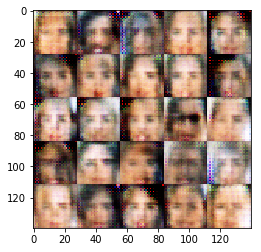

Batch 910/3165... Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.6975
Batch 920/3165... Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.5974
Batch 930/3165... Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 1.0366
Batch 940/3165... Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8036
Batch 950/3165... Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7838
Batch 960/3165... Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.4110
Batch 970/3165... Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9342
Batch 980/3165... Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 1.2749
Batch 990/3165... Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 2.1813
Batch 1000/3165... Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.9426


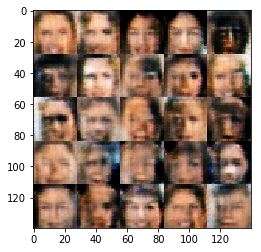

Batch 1010/3165... Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 1.5400
Batch 1020/3165... Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.3294
Batch 1030/3165... Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5662
Batch 1040/3165... Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8295
Batch 1050/3165... Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7573
Batch 1060/3165... Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.4511
Batch 1070/3165... Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.8633
Batch 1080/3165... Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8829
Batch 1090/3165... Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7461
Batch 1100/3165... Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5949


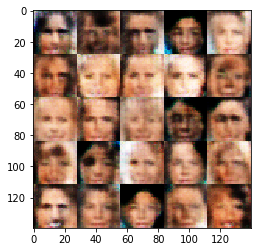

Batch 1110/3165... Epoch 1/1... Discriminator Loss: 1.7273... Generator Loss: 0.2921
Batch 1120/3165... Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 1.9115
Batch 1130/3165... Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 1.5054
Batch 1140/3165... Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 2.0874
Batch 1150/3165... Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.8770
Batch 1160/3165... Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8678
Batch 1170/3165... Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.6839
Batch 1180/3165... Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.2988
Batch 1190/3165... Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8208
Batch 1200/3165... Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.4408


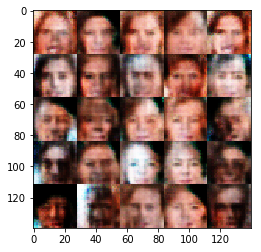

Batch 1210/3165... Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.6701
Batch 1220/3165... Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.8721
Batch 1230/3165... Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.1511
Batch 1240/3165... Epoch 1/1... Discriminator Loss: 1.6924... Generator Loss: 0.3174
Batch 1250/3165... Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.7296
Batch 1260/3165... Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.6609
Batch 1270/3165... Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8066
Batch 1280/3165... Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5688
Batch 1290/3165... Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.9964
Batch 1300/3165... Epoch 1/1... Discriminator Loss: 1.8037... Generator Loss: 1.5998


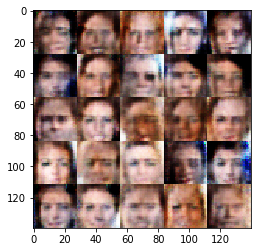

Batch 1310/3165... Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.4508
Batch 1320/3165... Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.5120
Batch 1330/3165... Epoch 1/1... Discriminator Loss: 1.8529... Generator Loss: 1.6485
Batch 1340/3165... Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 1.2950
Batch 1350/3165... Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.4562
Batch 1360/3165... Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7972
Batch 1370/3165... Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.3262
Batch 1380/3165... Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 1.0270
Batch 1390/3165... Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6715
Batch 1400/3165... Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.3589


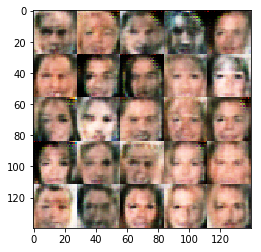

Batch 1410/3165... Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 0.2974
Batch 1420/3165... Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 1.5094
Batch 1430/3165... Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6119
Batch 1440/3165... Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.6836
Batch 1450/3165... Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.1714
Batch 1460/3165... Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.0549
Batch 1470/3165... Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6964
Batch 1480/3165... Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.0160
Batch 1490/3165... Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.2916
Batch 1500/3165... Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0227


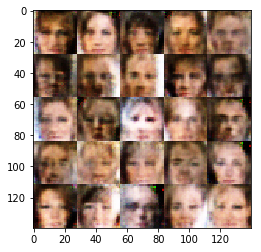

Batch 1510/3165... Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6871
Batch 1520/3165... Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9971
Batch 1530/3165... Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.4648
Batch 1540/3165... Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.6610
Batch 1550/3165... Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 1.2041
Batch 1560/3165... Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.9683
Batch 1570/3165... Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.9883
Batch 1580/3165... Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 1.0537
Batch 1590/3165... Epoch 1/1... Discriminator Loss: 2.1292... Generator Loss: 0.1839
Batch 1600/3165... Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 1.6218


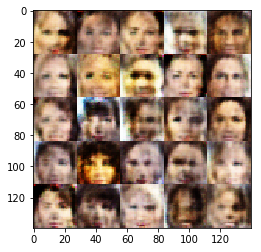

Batch 1610/3165... Epoch 1/1... Discriminator Loss: 1.6867... Generator Loss: 0.5490
Batch 1620/3165... Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8218
Batch 1630/3165... Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6819
Batch 1640/3165... Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 1.2843
Batch 1650/3165... Epoch 1/1... Discriminator Loss: 1.7243... Generator Loss: 0.7274
Batch 1660/3165... Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.6517
Batch 1670/3165... Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.3540
Batch 1680/3165... Epoch 1/1... Discriminator Loss: 1.9938... Generator Loss: 0.7228
Batch 1690/3165... Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.3231
Batch 1700/3165... Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5496


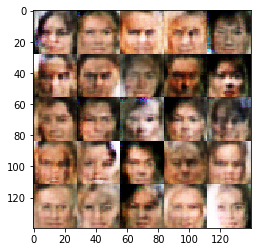

Batch 1710/3165... Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 2.4700
Batch 1720/3165... Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.0607
Batch 1730/3165... Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 1.5540
Batch 1740/3165... Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.9890
Batch 1750/3165... Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 1.2574
Batch 1760/3165... Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8435
Batch 1770/3165... Epoch 1/1... Discriminator Loss: 1.6428... Generator Loss: 0.3901
Batch 1780/3165... Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.5674
Batch 1790/3165... Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7431
Batch 1800/3165... Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.8355


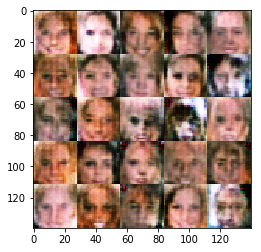

Batch 1810/3165... Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.5980
Batch 1820/3165... Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7668
Batch 1830/3165... Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 1.4276
Batch 1840/3165... Epoch 1/1... Discriminator Loss: 2.2440... Generator Loss: 0.1552
Batch 1850/3165... Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.1277
Batch 1860/3165... Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 1.4450
Batch 1870/3165... Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9859
Batch 1880/3165... Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.5321
Batch 1890/3165... Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.9771
Batch 1900/3165... Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5925


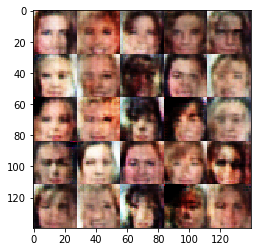

Batch 1910/3165... Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7310
Batch 1920/3165... Epoch 1/1... Discriminator Loss: 1.8887... Generator Loss: 0.3299
Batch 1930/3165... Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.7199
Batch 1940/3165... Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.2533
Batch 1950/3165... Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.2596
Batch 1960/3165... Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 1.0544
Batch 1970/3165... Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6919
Batch 1980/3165... Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7463
Batch 1990/3165... Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8874
Batch 2000/3165... Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 1.0390


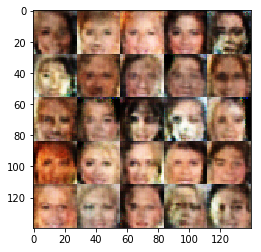

Batch 2010/3165... Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5741
Batch 2020/3165... Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.0200
Batch 2030/3165... Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6079
Batch 2040/3165... Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8079
Batch 2050/3165... Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8574
Batch 2060/3165... Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6571
Batch 2070/3165... Epoch 1/1... Discriminator Loss: 1.9994... Generator Loss: 0.4607
Batch 2080/3165... Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5523
Batch 2090/3165... Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.3812
Batch 2100/3165... Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.3274


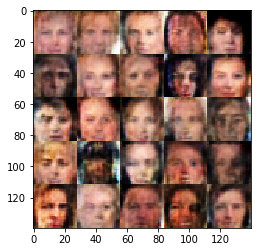

Batch 2110/3165... Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8304
Batch 2120/3165... Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.5726
Batch 2130/3165... Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.9117
Batch 2140/3165... Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.0875
Batch 2150/3165... Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.1674
Batch 2160/3165... Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.5971
Batch 2170/3165... Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 1.4434
Batch 2180/3165... Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 1.1550
Batch 2190/3165... Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8575
Batch 2200/3165... Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7165


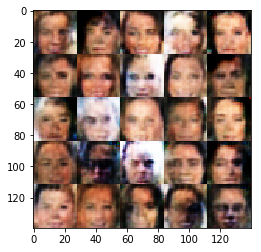

Batch 2210/3165... Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9018
Batch 2220/3165... Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7014
Batch 2230/3165... Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.7501
Batch 2240/3165... Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.7424
Batch 2250/3165... Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9339
Batch 2260/3165... Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.8086
Batch 2270/3165... Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.5602
Batch 2280/3165... Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.9853
Batch 2290/3165... Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6762
Batch 2300/3165... Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 1.0626


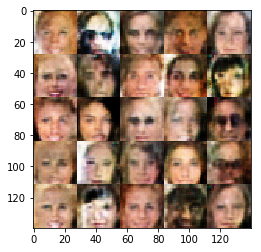

Batch 2310/3165... Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.4214
Batch 2320/3165... Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.4792
Batch 2330/3165... Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.5434
Batch 2340/3165... Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.7448
Batch 2350/3165... Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 1.4817
Batch 2360/3165... Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6519
Batch 2370/3165... Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6873
Batch 2380/3165... Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6702
Batch 2390/3165... Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6904
Batch 2400/3165... Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.9724


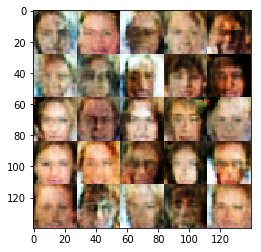

Batch 2410/3165... Epoch 1/1... Discriminator Loss: 1.9211... Generator Loss: 1.6738
Batch 2420/3165... Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.5382
Batch 2430/3165... Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7447
Batch 2440/3165... Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5750
Batch 2450/3165... Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.2299
Batch 2460/3165... Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6833
Batch 2470/3165... Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.9943
Batch 2480/3165... Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7880
Batch 2490/3165... Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.7142
Batch 2500/3165... Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9090


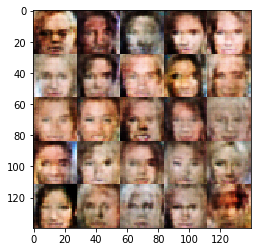

Batch 2510/3165... Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 1.0762
Batch 2520/3165... Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.1558
Batch 2530/3165... Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.7722
Batch 2540/3165... Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7849
Batch 2550/3165... Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.7661
Batch 2560/3165... Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7984
Batch 2570/3165... Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.6488
Batch 2580/3165... Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7193
Batch 2590/3165... Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.7987
Batch 2600/3165... Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.8069


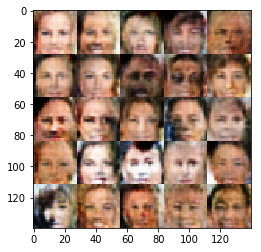

Batch 2610/3165... Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.1920
Batch 2620/3165... Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.6967
Batch 2630/3165... Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 1.1288
Batch 2640/3165... Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.5791
Batch 2650/3165... Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7145
Batch 2660/3165... Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6553
Batch 2670/3165... Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7685
Batch 2680/3165... Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.9953
Batch 2690/3165... Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6866
Batch 2700/3165... Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.4633


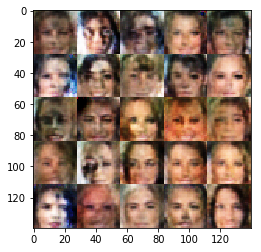

Batch 2710/3165... Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7621
Batch 2720/3165... Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8424
Batch 2730/3165... Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.1496
Batch 2740/3165... Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.4558
Batch 2750/3165... Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.0505
Batch 2760/3165... Epoch 1/1... Discriminator Loss: 1.7960... Generator Loss: 0.4337
Batch 2770/3165... Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.8280
Batch 2780/3165... Epoch 1/1... Discriminator Loss: 1.7302... Generator Loss: 0.3338
Batch 2790/3165... Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8278
Batch 2800/3165... Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7644


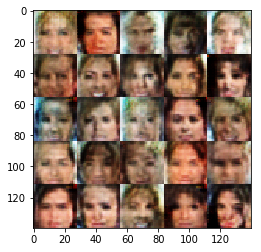

Batch 2810/3165... Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.5129
Batch 2820/3165... Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9175
Batch 2830/3165... Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.1922
Batch 2840/3165... Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.4329
Batch 2850/3165... Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 1.0068
Batch 2860/3165... Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.5472
Batch 2870/3165... Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.3983
Batch 2880/3165... Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.9176
Batch 2890/3165... Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8835
Batch 2900/3165... Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7970


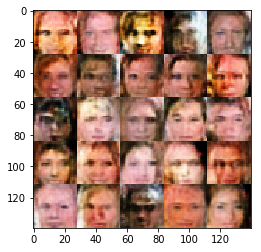

Batch 2910/3165... Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6490
Batch 2920/3165... Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7359
Batch 2930/3165... Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6569
Batch 2940/3165... Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6522
Batch 2950/3165... Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.6897
Batch 2960/3165... Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 0.2560
Batch 2970/3165... Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9096
Batch 2980/3165... Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.7927
Batch 2990/3165... Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.6438
Batch 3000/3165... Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7146


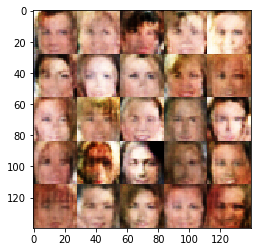

Batch 3010/3165... Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.4493
Batch 3020/3165... Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.5042
Batch 3030/3165... Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8247
Batch 3040/3165... Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.9897
Batch 3050/3165... Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6384
Batch 3060/3165... Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.9098
Batch 3070/3165... Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.4624
Batch 3080/3165... Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.0693
Batch 3090/3165... Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7073
Batch 3100/3165... Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 1.0244


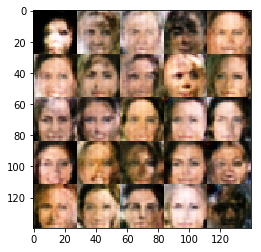

Batch 3110/3165... Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.4455
Batch 3120/3165... Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8988
Batch 3130/3165... Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.3373
Batch 3140/3165... Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7659
Batch 3150/3165... Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.9132
Batch 3160/3165... Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.9889


In [62]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
alpha=0.2
print_every=10
show_every=100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(
        epochs,
        batch_size,
        z_dim,
        learning_rate,
        beta1,
        celeba_dataset.get_batches,
        celeba_dataset.shape,
        celeba_dataset.image_mode,
        alpha,
        print_every,
        show_every
    )

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.